In [ ]:
%pip install patchify
%pip install opencv-python
%pip install pillow
%pip install scikit-learn
%pip install matplotlib
%pip install tensorflow
%pip install keras

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset_root_folder = 'satellite'

In [3]:
dataset_name = 'DubaiDataset'

In [10]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  if dir_name == "images":
    images = os.listdir(path)
    for i, image in enumerate(images):
      if (image.endswith('.jpg')):
        a = True

In [11]:
image_patch_size = 256

In [12]:
image_cv = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg', 1)
image_cv.shape

(644, 797, 3)

In [13]:
(image_cv.shape[1]//image_patch_size)*image_patch_size

768

In [14]:
minmaxScaler = MinMaxScaler()

In [15]:
imageDataset = []
maskDataset = []
for imageType in ['images', 'masks']:
  if imageType == "images":
    imageExtension = 'jpg'
  else:
    imageExtension = 'png'
  for tile_id in range(1, 8):
    for image_id in range(1, 20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{imageType}/image_part_00{image_id}.{imageExtension}', 1)
      if image is not None:
        if imageType == "masks":
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image.shape)
        size_x = (image_cv.shape[0]//image_patch_size)*image_patch_size
        size_y = (image_cv.shape[1]//image_patch_size)*image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        patches_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        # print(len(patches_images))
        for i in range(patches_images.shape[0]):
          for j in range(patches_images.shape[1]):
            if imageType == "images":
              single_pathches_image = patches_images[i, j, :, :, :]
              single_pathches_image = minmaxScaler.fit_transform(single_pathches_image.reshape(-1, single_pathches_image.shape[-1])).reshape(single_pathches_image.shape)
              single_pathches_image = single_pathches_image[0]
              # print(single_pathches_image[0].shape)
              imageDataset.append(single_pathches_image)
            else:
              single_pathches_mask = patches_images[i, j, :, :, :]
              single_pathches_mask = single_pathches_mask[0]
              maskDataset.append(single_pathches_mask)


In [16]:
print(len(imageDataset), len(maskDataset))

378 378


In [17]:
imageDataset = np.array(imageDataset)
maskDataset = np.array(maskDataset)

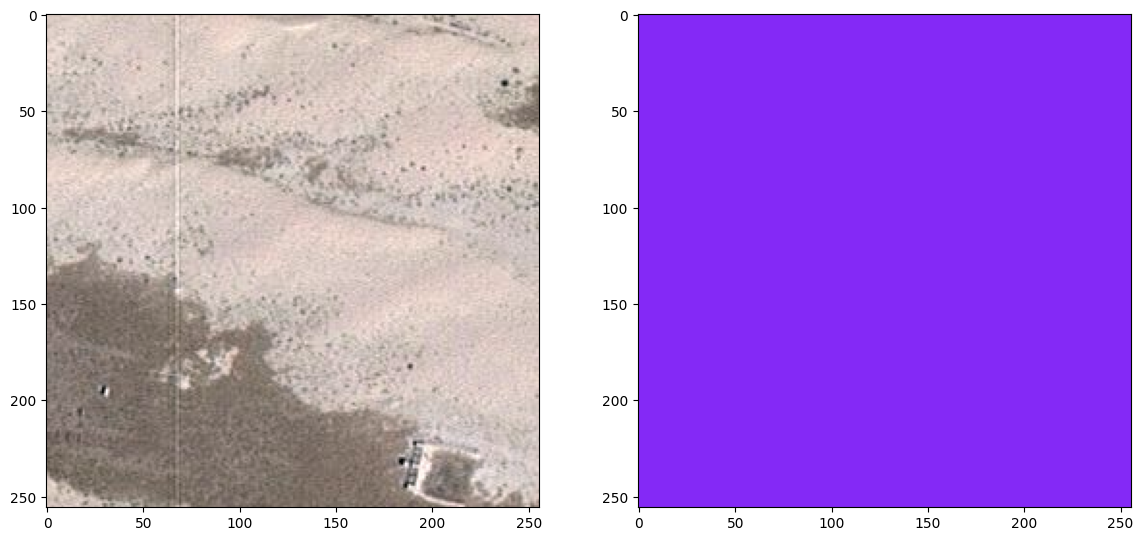

In [21]:
randomImageID = random.randint(0, len(imageDataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(imageDataset[randomImageID])
plt.subplot(122)
plt.imshow(maskDataset[randomImageID])

In [22]:
classBuilding = "#3C1098"
classBuilding = classBuilding.lstrip('#')
classBuilding = np.array(tuple(int(classBuilding[i:i+2], 16) for i in (0, 2, 4)))
print(classBuilding)

classLand = "#8429f6"
classLand = classLand.lstrip('#')
classLand = np.array(tuple(int(classLand[i:i+2], 16) for i in (0, 2, 4)))
print(classLand)

classRoad = "#6ec1e4"
classRoad = classRoad.lstrip('#')
classRoad = np.array(tuple(int(classRoad[i:i+2], 16) for i in (0, 2, 4)))
print(classRoad)

classVegetation = "#fedd3a"
classVegetation = classVegetation.lstrip('#')
classVegetation = np.array(tuple(int(classVegetation[i:i+2], 16) for i in (0, 2, 4)))
print(classVegetation)

classWater = "#e2a929"
classWater = classWater.lstrip('#')
classWater = np.array(tuple(int(classWater[i:i+2], 16) for i in (0, 2, 4)))
print(classWater)

classUnlabel = "#9b9b9b"
classUnlabel = classUnlabel.lstrip('#')
classUnlabel = np.array(tuple(int(classUnlabel[i:i+2], 16) for i in (0, 2, 4)))
print(classUnlabel)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [23]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == classWater, axis = -1)] = 0
  label_segment[np.all(label == classLand, axis = -1)] = 1
  label_segment[np.all(label == classRoad, axis = -1)] = 2
  label_segment[np.all(label == classBuilding, axis = -1)] = 3
  label_segment[np.all(label == classVegetation, axis = -1)] = 4
  label_segment[np.all(label == classUnlabel, axis = -1)] = 5
  label_segment = label_segment[:, :, 0]
  return label_segment

In [24]:
labelDataset = []

for i in range(maskDataset.shape[0]):
  label = rgb_to_label(maskDataset[i])
  labelDataset.append(label)

In [25]:
labelDataset = np.array(labelDataset)
labelDataset = np.expand_dims(labelDataset, axis=3)
labelDataset.shape

(378, 256, 256, 1)

In [26]:
print("Total unique labels based on mask: ", format(np.unique(labelDataset)))

Total unique labels based on mask:  [0 1 2 3 4 5]


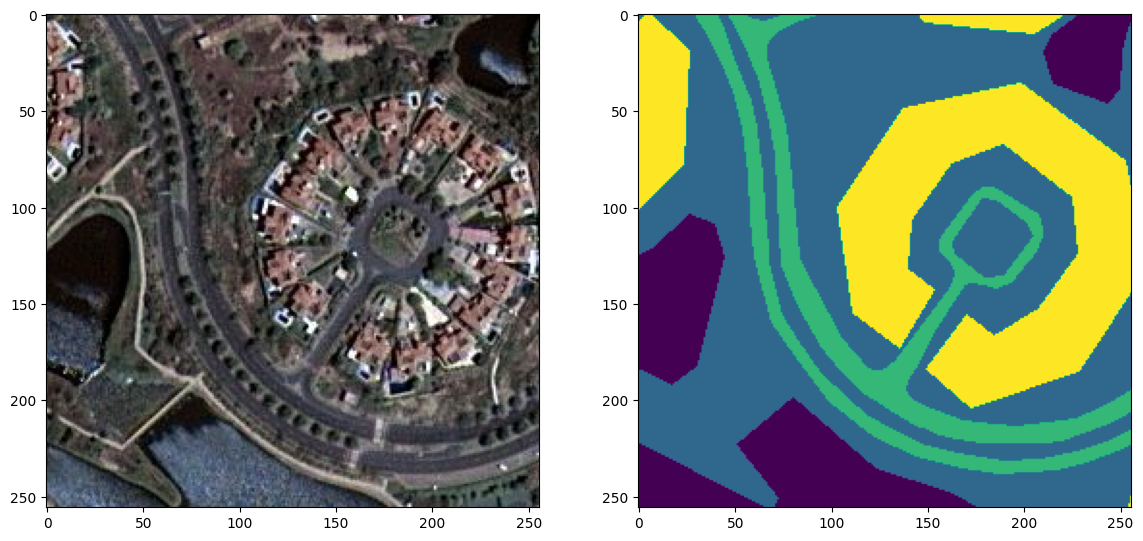

In [29]:
randomImageID = random.randint(0, len(imageDataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(imageDataset[randomImageID])
plt.subplot(122)
# plt.imshow(maskDataset[randomImageID])
plt.imshow(labelDataset[randomImageID][:,:,0])

In [30]:
masterTrainingDataset = imageDataset

In [31]:
total_classes = len(np.unique(labelDataset))

In [32]:
from tensorflow.keras.utils import to_categorical

In [33]:
labelCategoricalDataset = to_categorical(labelDataset, num_classes=total_classes)

In [34]:
from sklearn.model_selection import train_test_split

In [350]:
X_train, X_test, y_train, y_test = train_test_split(masterTrainingDataset, labelCategoricalDataset, test_size=.2, random_state=100)

In [114]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(321, 256, 256, 3)
(57, 256, 256, 3)
(321, 256, 256, 6)
(57, 256, 256, 6)


In [115]:
imageHeight = X_train.shape[1]
imageWidth = X_train.shape[2]
imageChannels = X_train.shape[3]
totalClasses = y_train.shape[3]

In [116]:
print(imageHeight)
print(imageWidth)
print(imageChannels)
print(totalClasses)

256
256
3
6


# Deep Learning

In [117]:
%pip install -U segmentation-models

Note: you may need to restart the kernel to use updated packages.


In [118]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization

In [119]:
import tensorflow.keras.backend as K

In [120]:
def jaccardCoef(y_true, y_pred):
    yTrueF = K.flatten(y_true)
    yPredF = K.flatten(y_pred)
    intersection = K.sum(yTrueF * yPredF)
    union = K.sum(yTrueF) + K.sum(yPredF) - intersection
    return (intersection + 1.) / (union + 1.)


In [417]:
def multiUnetModel(nClasses=5, imageHeight=256, imageWidth=256, imageChannels=1):
  inputs = Input((imageHeight, imageWidth, imageChannels))
  sourceInput = inputs

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (sourceInput)
  c1 = Dropout(.4) (c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(.4) (c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(.4) (c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(.4) (c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D((2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(.4) (c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(.4) (c6)
  c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(.4) (c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(.4) (c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis = 3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(.4) (c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(nClasses, (1, 1), activation='softmax') (c9)
  model = Model(inputs=[inputs], outputs=[outputs])
  return model


In [122]:
metrics = ['accuracy', jaccardCoef]

In [123]:
def getDeepLearningModel():
  return multiUnetModel(nClasses=totalClasses,
                        imageHeight=imageHeight,
                        imageWidth=imageWidth,
                        imageChannels=imageChannels)

In [124]:
model = getDeepLearningModel()

In [125]:
# model.get_config()

# Generating Loss Function

In [126]:
weights = [.1666, .1666, .1666, .1666, .1666, .1666]

In [127]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

In [128]:
diceLoss = sm.losses.DiceLoss(class_weights = weights)

In [129]:
focalLoss = sm.losses.CategoricalFocalLoss()

In [130]:
totalLoss = diceLoss + (1 * focalLoss)

# Model Compilation

In [131]:
import tensorflow as tf

In [387]:
tf.keras.backend.clear_session()

In [133]:
metrics

['accuracy', <function __main__.jaccardCoef(y_true, y_pred)>]

In [134]:
model.compile(optimizer='adam', loss=totalLoss, metrics=metrics)

In [135]:
# model.summary()

In [418]:
modelHistory = model.fit(X_train, y_train,
                         batch_size=7,
                         verbose=1,
                         epochs=10, 
                         validation_data = (X_test, y_test),
                         shuffle=False)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 673ms/step - accuracy: 0.9471 - jaccard_coef: 0.8837 - loss: 0.8627 - val_accuracy: 0.8793 - val_jaccard_coef: 0.7746 - val_loss: 0.9195
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.9464 - jaccard_coef: 0.8818 - loss: 0.8630 - val_accuracy: 0.8772 - val_jaccard_coef: 0.7727 - val_loss: 0.9216
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.9461 - jaccard_coef: 0.8822 - loss: 0.8632 - val_accuracy: 0.8760 - val_jaccard_coef: 0.7732 - val_loss: 0.9249
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 673ms/step - accuracy: 0.9453 - jaccard_coef: 0.8810 - loss: 0.8639 - val_accuracy: 0.8746 - val_jaccard_coef: 0.7691 - val_loss: 0.9238
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 638ms/step - accuracy: 0.9423 - jaccard_coef: 0.8743 - loss: 0.8649 - val_accuracy: 0.8753 - val_jaccard_coef: 0.7689 - val_loss: 0.9234
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 667ms/step - accuracy: 0.9426 - jaccard_coef: 0.8730 - loss: 0.

Text(0.5, 0, 'Epochs')

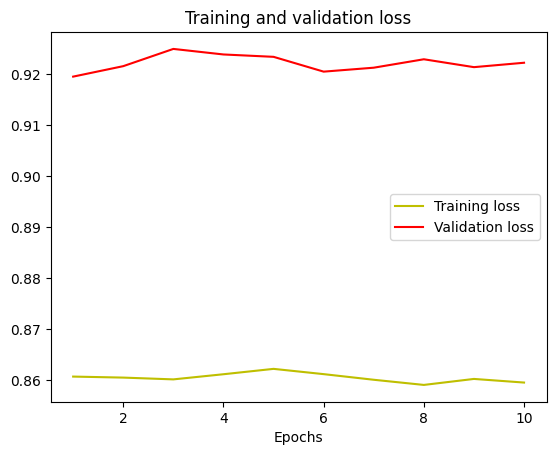

In [419]:
loss = modelHistory.history['loss']
valLoss = modelHistory.history['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, valLoss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

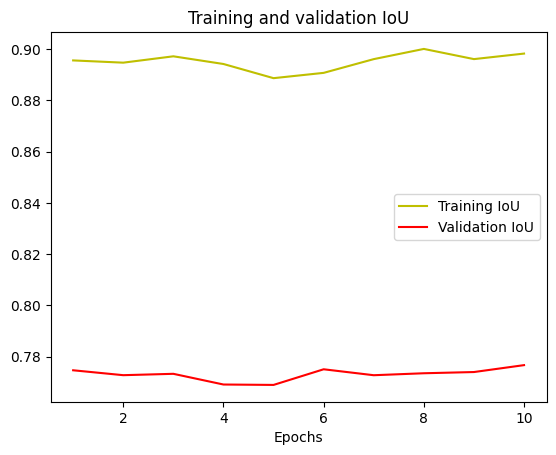

In [420]:
jaccardCoefHist = modelHistory.history['jaccard_coef']
valJaccardCoefHist = modelHistory.history['val_jaccard_coef']

epochs = range(1, len(loss)+1)
plt.plot(epochs, jaccardCoefHist, 'y', label='Training IoU')
plt.plot(epochs, valJaccardCoefHist, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.legend()
plt.xlabel('Epochs')

# Comparing Pred result

In [421]:
yPred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step


In [422]:
yPredMax = np.argmax(yPred, axis=3)
yTestMax = np.argmax(y_test, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


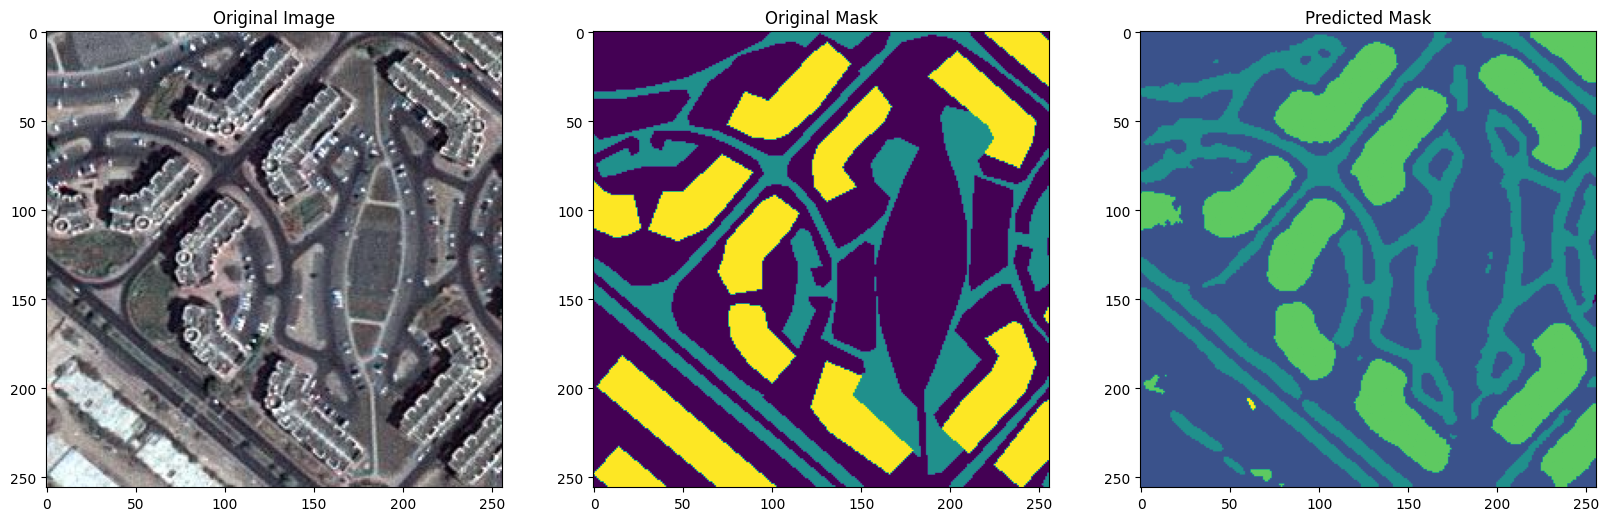

In [531]:
testImageNumber = random.randint(0, len(X_test)-1)

testImage = X_test[testImageNumber]
groundTruth = yTestMax[testImageNumber]

testImageInput = np.expand_dims(testImage, axis=0)

pred = model.predict(testImageInput)
predImage = np.argmax(pred, axis=3)[0,:,:]

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.title("Original Image")
plt.imshow(testImage)
plt.subplot(132)
plt.title("Original Mask")
plt.imshow(groundTruth)
plt.subplot(133)
plt.title("Predicted Mask")
plt.imshow(predImage)

In [532]:
model.save("Satellite_Imagery_Segmentation_3.h5")